# Likelihood based approaches

In this tutorial, we implement the maximum likelihood estimation approach and compare with variogram
fitting.

In [53]:
#Preamble 

import numpy as np
import gstlearn as gl
import gstlearn.plot as gp
import scipy as sc 
import matplotlib.pyplot as plt
np.random.seed(123134)

## Zero mean stationary GRF model

We first define a zero mean GRF $Z$ model through its covariance function:

In [54]:
# Creation of the coordinates
ndat = 200
x=np.random.uniform(size=ndat)
y=np.random.uniform(size=ndat)
dbsim = gl.Db.create()
dbsim["x"]=x
dbsim["y"]=y
dbsim.setLocators(["x","y"],gl.ELoc.X)

# Creation of the covariance model
rangeval = 0.3
model1 = gl.Model.createFromParam(gl.ECov.EXPONENTIAL,range = rangeval)

#Simulation of a data set
err=gl.simtub(None,dbsim,model=model1,nbtuba=1000)

#Split train and test (proportion 50%)
ind = np.arange(ndat)
np.random.shuffle(ind)
indtrain = ind[:int(ndat/2)]
indtest  = ind[int(ndat/2):]
dbtrain = gl.Db.createReduce(dbsim,ranks = indtrain)
dbtest = gl.Db.createReduce(dbsim,ranks = indtest)

## Empirical variogram approach

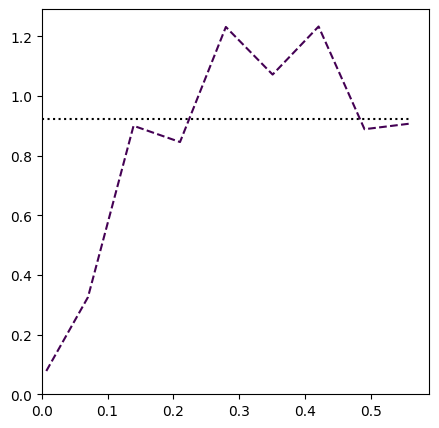

In [55]:
varioParamOmni = gl.VarioParam.createOmniDirection(npas=9, dpas=0.07, toldis=0.1)
vario = gl.Vario.computeFromDb(varioParamOmni,dbtrain)
gp.plot(vario)

In [56]:
fitmod = gl.Model()
err = fitmod.fit(vario)
fitmod


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Spherical
- Sill         =      1.068
- Range        =      0.255
Total Sill     =      1.068
Known Mean(s)     0.000

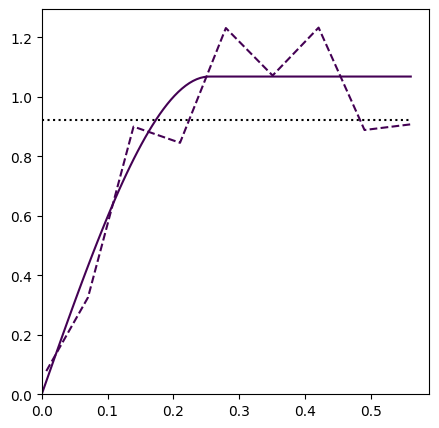

In [57]:
ax = gp.varmod(vario, fitmod)

### Evaluation of the covariance matrix

We use the method **evalCovMatrix** of the class **gl.Model**. The result is of type **gl.Matrix**. We use the method **gl.Matrix.toTL**  to transform it into a **np.array** (**toTL** helps you to transform an object of **gstlearn** into the Target Language, here python).

In [58]:
covmat = fitmod.evalCovMatrix(dbtrain).toTL()
covmat

array([[1.06842219, 0.        , 0.        , ..., 0.        , 0.41043248,
        0.        ],
       [0.        , 1.06842219, 0.        , ..., 0.        , 0.        ,
        0.0965311 ],
       [0.        , 0.        , 1.06842219, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.06842219, 0.        ,
        0.        ],
       [0.41043248, 0.        , 0.        , ..., 0.        , 1.06842219,
        0.        ],
       [0.        , 0.0965311 , 0.        , ..., 0.        , 0.        ,
        1.06842219]])

Here we define the likelihood function

In [59]:
np.random.seed(22)
C = np.random.uniform(size = (4,4))
C = C.T@C
np.linalg.slogdet(C)[1]

F = np.ones(shape=(ndat,1))
betavect = np.atleast_1d(0.3)
F@betavect

array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.

In [60]:
def neg2logLikelihood(db,model,sigma,theta,beta = 0.,F=None):
    ndat = db.getSampleNumber()
    if F is None:
        F = np.ones(shape=(ndat,1)) #Vector of 1 for the mean parameter
    
    model.getCova(0).setRangeIsotropic(theta) #Fix range of the covariance model
    model.getCova(0).setSill(sigma**2) #Sill
    z = dbtrain.getColumnByLocator(gl.ELoc.Z) #Get variable Z
    betavect = np.atleast_1d(beta) # make beta a vector (in case where a single value is given)
    C = model.evalCovMatrix(dbtrain).toTL() #Covariance matrix

    logdet = np.linalg.slogdet(C)[1] # log determinant
    Zc = z-F@betavect #Centered bvector
    Cm1Zc = np.linalg.solve(C,Zc)
    quad = Zc.T@Cm1Zc #Quadratic term
    return logdet + quad

In [61]:
modelMLE = fitmod.clone()
neg2logLikelihood(dbtrain,modelMLE,0.5,0.2,0.)

np.float64(328.9161106221892)

In [62]:
def neg2logLikelihoodForOptim(params,db,model,X=None):
    sigma = params[0]
    theta = params[1]
    beta = params[2:]  
    result = neg2logLikelihood(db,model,sigma,theta,beta,X)
    print("sill " +        str(np.round(sigma**2,2)) + 
          " range " +      str(np.round(theta,2)) +
          " mean " +       str(np.round(beta,2)) + 
          " likelihood " + str(np.round(result,2)))
    return result

def fitMLE(params,db,model,X = None):
    bds = ((0.00001,10),(0.00001,10)) + tuple((None, None) for _ in range(len(params)-2))
    return sc.optimize.minimize(neg2logLikelihoodForOptim,params,
                                args = (db,model,X),
                                bounds= bds)
                                
    
result = fitMLE(np.array([1,0.1,0.]),dbtrain,modelMLE)

sill 1.0 range 0.1 mean [0.] likelihood 71.49
sill 1.0 range 0.1 mean [0.] likelihood 71.49
sill 1.0 range 0.1 mean [0.] likelihood 71.49
sill 1.0 range 0.1 mean [0.] likelihood 71.49
sill 0.9 range 0.62 mean [0.86] likelihood 296.6
sill 0.9 range 0.62 mean [0.86] likelihood 296.6
sill 0.9 range 0.62 mean [0.86] likelihood 296.6
sill 0.9 range 0.62 mean [0.86] likelihood 296.6
sill 0.99 range 0.14 mean [0.07] likelihood 65.87
sill 0.99 range 0.14 mean [0.07] likelihood 65.87
sill 0.99 range 0.14 mean [0.07] likelihood 65.87
sill 0.99 range 0.14 mean [0.07] likelihood 65.87
sill 1.0 range 0.14 mean [0.07] likelihood 65.79
sill 1.0 range 0.14 mean [0.07] likelihood 65.79
sill 1.0 range 0.14 mean [0.07] likelihood 65.79
sill 1.0 range 0.14 mean [0.07] likelihood 65.79
sill 1.01 range 0.12 mean [0.08] likelihood 67.08
sill 1.01 range 0.12 mean [0.08] likelihood 67.08
sill 1.01 range 0.12 mean [0.08] likelihood 67.08
sill 1.01 range 0.12 mean [0.08] likelihood 67.08
sill 1.0 range 0.14 mean

In [63]:
-fitmod.computeLogLikelihood(dbtrain) -  ndat/2 * np.log(2*np.pi)

np.float64(-50.31000919947536)

Estimated parameters 

In [64]:
result.x

array([1.01417351, 0.13901656, 0.10554673])

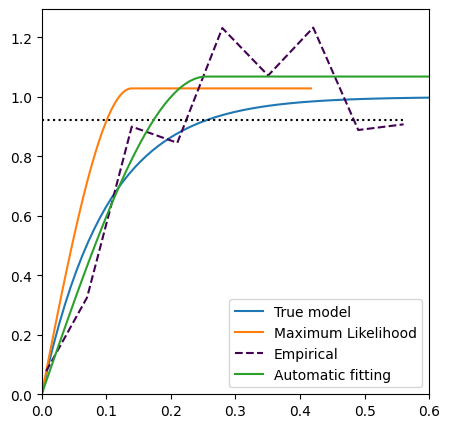

In [65]:
gp.plot(model1,label="True model")
gp.plot(modelMLE,label="Maximum Likelihood")
gp.plot(vario,label="Empirical")
gp.plot(fitmod,label="Automatic fitting")
plt.xlim([0,0.6])
aa=plt.legend()


Comparison with the Simple kriging with the mean estimated by maximum likelihood and ordinary kriging with the fitted model

In [66]:
modelMLE.setMean(result.x[2])

In [67]:
gl.kriging(dbtrain,dbtest,modelMLE,gl.NeighUnique(),namconv=gl.NamingConvention("MLE"))

0

In [68]:
fitmod.setDriftIRF(0)
gl.kriging(dbtrain,dbtest,fitmod,gl.NeighUnique(),namconv=gl.NamingConvention("OK"))

0

In [69]:
krigingVario = dbtest["MLE*estim"]
krigingMLE = dbtest["OK*estim"]

In [82]:
print("MSE with MLE " + str(np.mean((krigingMLE-dbtest["Simu"])**2)))
print("MSE with vario " + str(np.mean((krigingVario-dbtest["Simu"])**2)))

MSE with MLE 13.561143140062656
MSE with vario 13.50470884640461


## First order non stationary GRF model

We now add a trend term $Z_2(x, y) = a + bx + cy + Z(x, y)$

In [71]:
beta = np.array([1,2,3])

#We duplicate the coordinates and affect them the role of a drift (locator F)
dbsim["v1"] = dbsim["x"]
dbsim["v2"] = dbsim["y"]
dbsim.setLocators(["v*"],gl.ELoc.F)

X = np.hstack([np.ones(shape=(ndat,1)),dbsim["v*"]]) #We stack a column of ones

#We add the total drift to the GRF
dbsim["Simu"] = X@beta + dbsim["Simu"]

#Split as previously
dbtrain = gl.Db.createReduce(dbsim,ranks = indtrain)
dbtest = gl.Db.createReduce(dbsim,ranks = indtest)

In [72]:
dbsim


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 200

Variables
---------
Column = 0 - Name = x - Locator = x1
Column = 1 - Name = y - Locator = x2
Column = 2 - Name = Simu - Locator = z1
Column = 3 - Name = v1 - Locator = f1
Column = 4 - Name = v2 - Locator = f2

In [73]:
#We specify to the model that there are two drift variables
fitmod.setDriftIRF(nfex = 2)
fitmod


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 3
Number of drift equation(s)  = 3

Covariance Part
---------------
Spherical
- Sill         =      1.068
- Range        =      0.255
Total Sill     =      1.068

Drift Part
----------
Universality_Condition
External_Drift:0
External_Drift:1

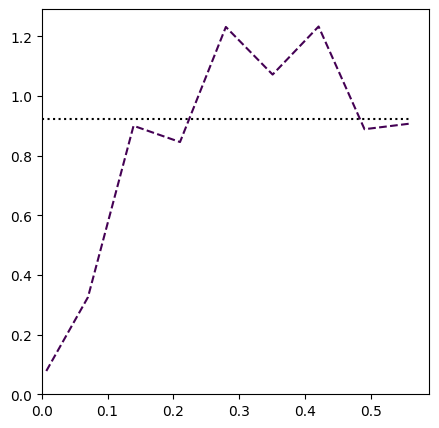

In [74]:
#Variogram of the residuals
varioKED =gl.Vario.computeFromDb(varioParamOmni,dbtrain,model=fitmod)
gp.plot(vario)

In [75]:
result = fitMLE(np.array([1,0.1,0.,0.,0.]),dbtrain,modelMLE,X[indtrain,:])

sill 1.0 range 0.1 mean [0. 0. 0.] likelihood 1081.73
sill 1.0 range 0.1 mean [0. 0. 0.] likelihood 1081.73
sill 1.0 range 0.1 mean [0. 0. 0.] likelihood 1081.73
sill 1.0 range 0.1 mean [0. 0. 0.] likelihood 1081.73
sill 1.0 range 0.1 mean [0. 0. 0.] likelihood 1081.73
sill 1.0 range 0.1 mean [0. 0. 0.] likelihood 1081.73
sill 1.03 range 0.12 mean [0.78 0.42 0.47] likelihood 480.15
sill 1.03 range 0.12 mean [0.78 0.42 0.47] likelihood 480.15
sill 1.03 range 0.12 mean [0.78 0.42 0.47] likelihood 480.15
sill 1.03 range 0.12 mean [0.78 0.42 0.47] likelihood 480.15
sill 1.03 range 0.12 mean [0.78 0.42 0.47] likelihood 480.15
sill 1.03 range 0.12 mean [0.78 0.42 0.47] likelihood 480.15
sill 1.04 range 0.1 mean [2.18 1.18 1.32] likelihood 94.0
sill 1.04 range 0.1 mean [2.18 1.18 1.32] likelihood 94.0
sill 1.04 range 0.1 mean [2.18 1.18 1.32] likelihood 94.0
sill 1.04 range 0.1 mean [2.18 1.18 1.32] likelihood 94.0
sill 1.04 range 0.1 mean [2.18 1.18 1.32] likelihood 94.0
sill 1.04 range 0.1 

In [76]:
gl.kriging(dbtrain,dbtest,fitmod,gl.NeighUnique(),namconv=gl.NamingConvention("KED"))

0

In [77]:
dbtrain


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 100

Variables
---------
Column = 0 - Name = x - Locator = x1
Column = 1 - Name = y - Locator = x2
Column = 2 - Name = Simu - Locator = z1
Column = 3 - Name = v1 - Locator = f1
Column = 4 - Name = v2 - Locator = f2

Kriging (residuals) by using the maximul likelihood estimations.

In [78]:
#Computation of the residuals
dbtrain["residual"] =  dbtrain["Simu"]-X[indtrain,:]@result.x[2:]
dbtrain.setLocator("residual",gl.ELoc.Z)
modelMLE.setMean(0)
gl.kriging(dbtrain,dbtest,modelMLE,gl.NeighUnique(),namconv=gl.NamingConvention("MLE"))

0

In [79]:
np.mean((dbtest["Simu"]-dbtest["KED*estim"])**2)

np.float64(0.6205353150656869)

In [80]:
dbtest["krigingMLE"] = dbtest["MLE.residual.estim"]+ X[indtest,:]@result.x[2:]

In [81]:
np.mean((dbtest["Simu"]-dbtest["krigingMLE"])**2)

np.float64(0.6115152963989126)

## Exercises

1. Repeat the procedure for 100 simulations for both models and methods. Print a table containing the mean and
standard deviation of the estimated parameter values and the MSEs.
2. Implement the profile log-likelihood